# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

##  Business Understanding:

This capstone project is aim to answer following questions:

1. What are the main drivers of an effective offer on the Starbucks app? (Drivers of the offer usage)
2. Could the data provided, namely offer characteristics and user demographics, predict whether a user would take up an offer? ( Effectiveness of the offers)

In [1]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from time import time
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

##  Data Understanding:

#### profile.json:
Rewards program users (17000 users x 5 fields). Demographic data for each customer

    gender: (categorical) M, F, O, or null
    age: (numeric) missing value encoded as 118
    id: (string/hash)
    became_member_on: (date) format YYYYMMDD
    income: (numeric)

#### portfolio.json:
Offers sent during 30-day test period (10 offers x 6 fields). Containing offer ids and meta data about each offer (duration, type, etc.)

    reward: (numeric) money awarded for the amount spent
    channels: (list) web, email, mobile, social
    difficulty: (numeric) money required to be spent to receive reward
    duration: (numeric) time for offer to be open, in days
    offer_type: (string) bogo, discount, informational
    id: (string/hash)

#### transcript.json:
Event log (306648 events x 4 fields). Records for transactions, offers received, offers viewed, and offers completed


    person: (string/hash)
    event: (string) offer received, offer viewed, transaction, offer completed
    value: (dictionary) different values depending on event type
    offer id: (string/hash) not associated with any "transaction"
    amount: (numeric) money spent in "transaction"
    reward: (numeric) money gained from "offer completed"
    time: (numeric) hours after start of test

*****To gain a deeper understanding of the problem in the following sections, it is important to initially examine the datasets, including identifying any missing values and visualizing the distribution of the data. This will provide insight into the dataset's structure and help us transform the data into suitable features for modeling purposes.*****

### 1. Portfolio Dataset:

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

*****As shown above there is no missing values*****

In [4]:
# Offers of each type
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [5]:
# Unique offers
portfolio.id.nunique()

10

### 2. Profile Dataset:

In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [8]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


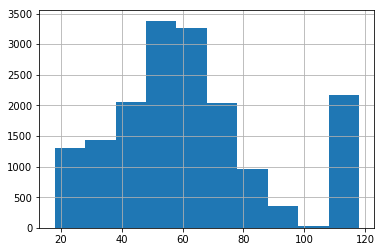

In [9]:
profile.age.hist()

In [10]:
#Age Column
profile[profile.age == 118]

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


*****It is noticeable that the age value is consistently 118 for all rows with missing values in the gender and income columns. Therefore, we can simply remove these rows to clean the data.*****

In [11]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

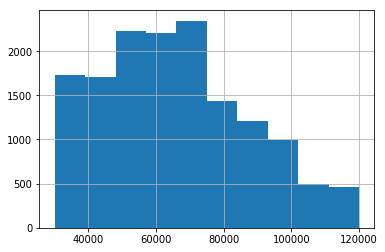

In [12]:
# Income Distribution
profile.income.hist();

Finally, it is worth noting that the column "became_member_on" could be potentially transformed into a new feature that represents the membership tenure in days. This new feature could potentially affect the effectiveness of an offer.

In [13]:
profile.became_member_on.head()

0    20170212
1    20170715
2    20180712
3    20170509
4    20170804
Name: became_member_on, dtype: int64

### 3. Transactional Dataset:

In [14]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [15]:
#check for missing value
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [16]:
transcript.groupby('event')['person'].count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

In [17]:
# expand the values into individual columns depending on the event
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [18]:
# Merge offer id into one column
transcript['offer_id_new']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

#drop unnecessary offer_id column
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)

#rename offer_id column
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

In [19]:
#rename column in portfolio
portfolio.rename(columns={'id':'offer_id'},inplace=True)

#join transcript with offer type
transcript=transcript.merge(portfolio,how='left',on='offer_id')

In [20]:
transcript.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

The data contains four types of events: offer completed, offer received, offer viewed, and transaction. 
However, transactions are not associated with any offer_id in the transcript event data, which makes it necessary to establish a method to assign offer_ids to specific transactions during data preprocessing.

BOGO and discount offers have an offer completed event when they are completed, whereas informational offers do not. Therefore, an effective offer for BOGO and discount offers would be defined based on the following sequence of events in time: offer received -> offer viewed -> transaction -> offer completed. 

On the other hand, for informational offers, since there is no offer completed event, transactions will be defined as a conversion to an effective offer based on the following sequence of events in time: offer received -> offer viewed -> transaction.

##  Data Pre-processing:

### a. Assigning offer ids to transactions

After establishing the methodology mentioned earlier, the next step is to explore techniques to allocate offer_ids to individual transactions. This involves identifying the main customer groups, which can be categorized into the following groups:

1. People who are influenced and successfully convert - effective offers:

    - `offer received` -> `offer viewed` -> `transaction` -> `offer completed` (BOGO/discount offers)
    - `offer received` -> `offer viewed` -> `transaction` (informational offers - must be within validity period of offer)

2. People who received and viewed an offer but did not successfully convert - ineffective offers:

    - `offer received` -> `offer viewed`

3. People who purchase/complete offers regardless of awareness of any offers:

    - `transaction`
    - `offer received` -> `transaction` -> `offer completed` -> `offer viewed`
    - `transaction` -> `offer received` -> `offer completed` -> `offer viewed`
    - `offer received` -> `transaction` -> `offer viewed` -> `offer completed`
    - `offer received` -> `transaction` (informational offers)
    - `offer received` -> `transaction` -> `offer viewed` (informational offers)

4. People who received offers but no action taken:

    - `offer received`


To assign offer_ids to specific transactions, we need to consider four main groups of customers.

For group 2, we need to identify cases where customers received and viewed an offer but did not convert it. It is important to differentiate them from customers in group 4 who did not even view the offer. 

Separating the conversions for effective offers (group 1) and people who purchased regardless of offer (group 3) is challenging. 
To define the target variable "effective_offer", we can consider group 2 as ineffective offers. 

For groups 3 and 4, we can deprioritize them from our model as they are less likely to respond to offers. 

The next step is to assign offer_ids to transactions. 

We can filter the transcript dataset by offer viewed and transaction events and use the pandas' ffill() method to fill each transaction with the offer_id of the viewed offer, only if it occurs before the transaction.

In [21]:
# drop the useless columns
transcript_processed = pd.DataFrame(transcript)
transcript_processed.drop(['reward_x', 'reward_y'], axis=1, inplace=True)
transcript_processed.head()

,event,person,time,value,amount,offer_id,channels,difficulty,duration,offer_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5.0,7.0,bogo
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,10.0,discount
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,discount
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,10.0,discount
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10.0,5.0,bogo


In [22]:
# sort the events by person and time
transcript_processed = transcript_processed.sort_values(['person','time'])
transcript_processed.head()

,event,person,time,value,amount,offer_id,channels,difficulty,duration,offer_type
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational
89291,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,NaN,NaN,NaN,NaN
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational


In [23]:
#ffilter dataset for transactions that occur after an offer is viewed, forward fill offer ids by person
offer_completed = transcript_processed[['time','offer_id','person','event']][(transcript_processed['event']\
    =='transaction') | (transcript_processed['event']=='offer viewed')]
offer_completed.update(offer_completed.groupby(['person']).ffill())
offer_completed['offer_id'] = offer_completed['offer_id'].ffill()

In [24]:
#Based on the temporary dataset created above, a new dataset can be generated by filling in offer ids for transactions. This new dataset will be based on the complete transcript dataset.
transcript_processed = transcript_processed.merge(offer_completed, how='left', on=['person','time','event'])
transcript_processed.head()

,event,person,time,value,amount,offer_id_x,channels,difficulty,duration,offer_type,offer_id_y
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed


In [25]:
# removing the dummy columns)
transcript_processed['offer_id'] = np.where(transcript_processed['offer_id_x'].isnull(),\
                                            transcript_processed['offer_id_y'], transcript_processed['offer_id_x'])
transcript_processed.drop(columns=['offer_id_x','offer_id_y'], axis=1, inplace=True)

In [26]:
#merge portfolio dataset to get offer data
transcript_processed = transcript_processed.merge(portfolio, how = 'left',on='offer_id')
transcript_processed['duration'] = np.where(transcript_processed['duration_x'].isnull(), \
                                            transcript_processed['duration_y'], transcript_processed['duration_x'])
transcript_processed.drop(columns=['duration_x','offer_type_x','difficulty_x','channels_x','duration_y'],\
                         axis=1, inplace=True)
transcript_processed.rename(columns={'channels_y':'channels','reward_y':'reward','difficulty_y':'difficulty','offer_type_y':'offer_type'},inplace=True)

In [27]:
# quick check on processed dataset
transcript_processed.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0


### b. Flagging transactions and offers completed after offers viewed

The subsequent crucial stage in preparing our data for modeling and analysis is to recognize a completed offer and transactions that follow an offer viewed.

After assigning a transaction that occurs after an offer is viewed, I can utilize that information to filter my data based on the groups defined earlier and analyze within each group.

As we have already filled in all transaction's offer ids, we can extract the transactions that converted from offers by checking if the offer id before the transaction matches the transaction's offer id.

This implies that if the events offer viewed, transaction, and offer completed are in the same event space and are in the correct sequence of time, we can ensure that it is a transaction and/or completed offer that only occurs after an offer is viewed.

To accomplish this, I generated a new column using pandas' shift function to label the preceding offer id.

In [28]:
# subset the dataset with only offer viewed, transaction, and offer completed events
transactions_after_viewed = transcript_processed[(transcript_processed['event']=='offer viewed')|\
                                                 (transcript_processed['event']=='transaction')|\
                                                 (transcript_processed['event']=='offer completed')].copy()

# generate the previous offer id
transactions_after_viewed['pre_offer_id'] = transactions_after_viewed.groupby(['person', 'offer_id'])['offer_id'].shift()

# create flag for responsed offer which competed after customer viewing the offer
transactions_after_viewed['completed_offer'] = np.where(transactions_after_viewed['pre_offer_id']==\
                                                       transactions_after_viewed['offer_id'],1,0)

In [29]:
transactions_after_viewed.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,pre_offer_id,completed_offer
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837,1
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,0
6,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57},8.57,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,3f207df678b143eea3cee63160fa8bed,1
7,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,NaN,0


In [30]:
# join back the 'offer received' events which was filtered out in the previous step
offer_received = transcript_processed[transcript_processed['event']=='offer received']

offer_received['pre_offer_id']=np.nan
offer_received['completed_offer']=np.nan

transcript_processed = offer_received.append(transactions_after_viewed).sort_values(['person','time'])
transcript_processed.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,pre_offer_id,completed_offer
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,0.0


To facilitate analysis, it's important to separate the transcript data by offer type as different offers have different completion consequences. For example, an informational offer does not offer rewards, while a discount or BOGO offer does.

In [31]:
#split transcript into 3 different offer types
bogo = transcript_processed[transcript_processed['offer_type']=='bogo'].copy()
discount = transcript_processed[transcript_processed['offer_type']=='discount'].copy()
informational = transcript_processed[transcript_processed['offer_type']=='informational'].copy()

In [32]:
bogo.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,pre_offer_id,completed_offer
5,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,NaN,NaN
7,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,NaN,0.0
8,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,f19421c1d4aa40978ebb69ca19b0e20d,1.0
10,transaction,0009655768c64bdeb2e877511632db8f,528,{'amount': 14.11},14.11,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,f19421c1d4aa40978ebb69ca19b0e20d,1.0
20,offer received,00116118485d4dfda04fdbaba9a87b5c,168,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,NaN,NaN


In [33]:
discount.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,pre_offer_id,completed_offer
9,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,discount,2,10.0,NaN,NaN
11,offer completed,0009655768c64bdeb2e877511632db8f,528,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,discount,2,10.0,NaN,0.0
12,offer viewed,0009655768c64bdeb2e877511632db8f,540,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,discount,2,10.0,fafdcd668e3743c1bb461111dcafc2a4,1.0
13,transaction,0009655768c64bdeb2e877511632db8f,552,{'amount': 13.56},13.56,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,discount,2,10.0,fafdcd668e3743c1bb461111dcafc2a4,1.0
14,offer received,0009655768c64bdeb2e877511632db8f,576,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10,discount,2,7.0,NaN,NaN


In [34]:
informational.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,pre_offer_id,completed_offer
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,0.0


After separating the transcript data by offer type, we can easily isolate each unique person-offer_id in group 1 from the other groups using the completed_offer column. By flagging all conversion events occurring after an offer viewed event, we can ensure that any conversion events with valid_completed=1 are at least in the first group of people who are influenced and successfully convert (effective offers).

For BOGO and discount offers, we will only consider offer completed events as the conversion events. On the other hand, we can consider the transaction event as the conversion event for the informational offers. This distinction is important because the different offer types have different consequences for completion. For example, informational offers do not provide rewards.

In [35]:
## Defining Group1 peoples

bogo_completed = bogo[['person','offer_id']][(bogo['completed_offer']==1) & (bogo['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()
discount_completed = discount[['person','offer_id']][(discount['completed_offer']==1) & (discount['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()

The next step is to separate group 2 and group 4 unique person-offer_ids for BOGO and discount offers. However, for informational offers, we need to consider an additional criterion for transactions to be effective offers - they need to occur within the offer's validity period. Therefore, we will define group 1 for informational offers later. Since it's safe to assume that every person who views an offer would have received the offer prior, we can just take the entire group of people who received an offer and subset them into group 2 and 4 for BOGO and discount offers.

In [36]:
#again, we define a function as we will repeat this for 2 datasets - BOGO & discount
def not_converted(df):
    '''
    Takes in transcript dataframe of single offer type to check for people of group2 and group4.

    inputs:
    - df: original transcript dataframe of specific offer type 

    outputs:
    - Returns dataframe containing unique person-offer_id pairs with conversion events and offers received events, with indicator of each.

    Note: left_only indicator is just the offers received events, right_only is just conversion events (transaction and offer_completed)

    '''
    #subset offer ids that have transactions or conversions by person and offer_id
    conversion_ids=df[['person','offer_id']][(df['event']=='transaction') | (df['event']=='offer completed') ].groupby(['person','offer_id']).count().reset_index()

    #check for unique person-offer_id pairs that consist of offers received 
    offers_received_only=df[['person','offer_id']][df['event']=='offer received'].groupby(['person','offer_id']).count().reset_index()

    #create merged dataset to diffrentiate groups
    check_merge=conversion_ids.merge(offers_received_only,how='right',on=['person','offer_id'],indicator=True)
    return check_merge

#check how many are in either group
check_merge_bogo=not_converted(bogo)
print('For BOGO offers:')
print(check_merge_bogo.groupby(['_merge']).count())

check_merge_discount=not_converted(discount)
print('For Discount offers:')
print(check_merge_discount.groupby(['_merge']).count())

For BOGO offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    4729      4729
both         20592     20592
For Discount offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    6415      6415
both         18901     18901



There exist a considerable number of person-offer_id pairs that have received an offer event but did not lead to a conversion event. These pairs will be classified into groups 2 and 4 for each offer type. Then, we can use the merged dataset to identify customers who only viewed the offer after receiving it and those who did not even open the offer.

In [37]:
grp_2_4_bogo = check_merge_bogo[check_merge_bogo['_merge'] == 'right_only']
grp_2_4_bogo  = grp_2_4_bogo.merge(transcript_processed,how='left',on=['person','offer_id'])
grp_2_bogo = grp_2_4_bogo[['person','offer_id']][grp_2_4_bogo['event'] == 'offer viewed'].groupby(['person','offer_id']).count().reset_index()
grp_2_4_bogo.drop(['_merge'], axis=1, inplace=True)
grp_4_bogo=grp_2_4_bogo.merge(grp_2_bogo[['person','offer_id']],how='left',indicator=True)
grp_4_bogo=grp_4_bogo[grp_4_bogo['_merge']=='left_only'].copy()

In [38]:
# do the same action on discount offer

# subtract the customers who received the offer without finishing the transaction
grp_2_4_discount = check_merge_discount[check_merge_discount['_merge']=='right_only']
grp_2_4_discount = grp_2_4_discount.merge(transcript_processed, how='left',on=['person','offer_id'])

# subset users who only viewed the offer and people who viewed the offer but didn't make transaction
grp_2_discount = grp_2_4_discount[['person','offer_id']][grp_2_4_discount['event']=='offer viewed']\
                .groupby(['person','offer_id']).count().reset_index()
grp_2_4_discount.drop(['_merge'], axis=1, inplace=True)

# get the customers who didn't even view the offer after they received the discount offer 
grp_4_discount = grp_2_4_discount.merge(grp_2_discount[['person','offer_id']], how='left', indicator=True)
grp_4_discount = grp_4_discount[grp_4_discount['_merge']=='left_only'].copy()

Group 3 comprises people who have conversion events, i.e., transaction or offer completed events, but no prior offer viewed events. In other words, they are the unique person-offer_id pairs that have completed an offer but did not view the offer beforehand. For BOGO and discount offers, group 3 would be composed of unique person-offer_id pairs with offer completed events and completed_offer flag not equal to 1.

In [39]:
# subset the offer which has no correction with offer
grp3_bogo = bogo[['person','offer_id']][(bogo['event']=='offer completed') & (bogo['completed_offer']!=1)]\
                    .groupby(['person','offer_id']).count().reset_index()
grp3_discount = discount[['person','offer_id']][(discount['event']=='offer completed')\
                    & (discount['completed_offer']!=1)].groupby(['person','offer_id']).count().reset_index()

To proceed, we need to consider effective and ineffective offers based on the group type. As explained earlier, any unique person-offer_id in group 1 can be considered as an effective offer, so we can assign effective_offer=1 for this group. Conversely, group 2 can be assigned effective_offer=0.

In [40]:
def final_offers_dataset(grp1, grp2):
    '''
    Combines two dataframes of customer data and adds an 'effective_offer' column indicating whether or not an offer was effective for a given customer.
    
    Inputs:
    - grp1: a dataframe containing group1 customer data
    - grp2: a dataframe containing group2 customer data
    
    Outputs:
    - A dataframe with labeled effective offer column.
    '''
    # Assign effective offer flag column
    grp1['effective_offer'] = 1
    grp2['effective_offer'] = 0

    # Append datasets together
    offers = grp1.append(grp2, sort=False)
    return offers

offers_bogo=final_offers_dataset(bogo_completed,grp_2_bogo)
offers_discount=final_offers_dataset(discount_completed,grp_2_discount)

The target variables for our BOGO and discount datasets have been prepared. However, for the informational offers, we need to consider the validity of the offer before we can tag the effective offers column.

### c. Considering duration of offers for informational offers to mark them as converted

The informational offers have a different rule for determining an effective/converted transaction or offer. This is because the conversion event is not an offer completed event but a transaction. For informational offers, an offer is only considered effective if the transaction occurs within the duration of the offer.

Since the time in the transcript data is in terms of hours while the duration of the offer is in days, we need to convert the time data into days to ensure they are on the same scale as the offer duration. This is done because the time data in the offers dataset is already in days.

In [41]:
#convert time into days
informational['day_offer']=informational['time']/24
#drop columns
informational.drop(['time','value','pre_offer_id'], axis=1, inplace=True)

In [42]:
#sort transactions by person and offer
informational=informational.sort_values(['person','day_offer','event','offer_id'])

In [43]:
#get difference in time for informational offers
informational['diff']=informational[(informational['offer_type']=='informational') & ((informational['event']=='offer received') | (informational['event']=='transaction'))].groupby(['person','offer_id'])['day_offer'].diff()

In [44]:
#create column for flagging valid events
informational['valid_completed_duration']=np.nan
#flag valid events if within duration
informational.loc[informational['diff']<=informational['duration'],'valid_completed_duration']=1
#fill any missing values with 0 flag
informational['valid_completed_duration']=informational['valid_completed_duration'].fillna(value=0)

In [45]:
informational.head()

,event,person,amount,offer_id,channels,difficulty,offer_type,reward,duration,completed_offer,day_offer,diff,valid_completed_duration
0,offer received,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,7.0,NaN,0.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,0.0,8.0,NaN,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,1.0,9.5,2.5,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,14.0,NaN,0.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,0.0,15.5,NaN,0.0


In [46]:
#flag effective_offers that completed_offer = 1 and valid_completed_duration = 1
informational['offer_responded']=np.where(((informational['completed_offer']==1)\
                                           & (informational['valid_completed_duration']==1)),1,0)

In [47]:
informational.head()

,event,person,amount,offer_id,channels,difficulty,offer_type,reward,duration,completed_offer,day_offer,diff,valid_completed_duration,offer_responded
0,offer received,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,7.0,NaN,0.0,0
1,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,0.0,8.0,NaN,0.0,0
2,transaction,0009655768c64bdeb2e877511632db8f,22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,1.0,9.5,2.5,1.0,1
3,offer received,0009655768c64bdeb2e877511632db8f,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,14.0,NaN,0.0,0
4,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,0.0,15.5,NaN,0.0,0


In [48]:
#separate group 1 in transcript_into
info_completed = informational[['person','offer_id']][informational['offer_responded']==1]\
                        .groupby(['person','offer_id']).sum().reset_index()

We need to split the remaining people into group 2 and 4, which can be done using the same method as BOGO and discount offers since there is no duration consideration for informational offers.

In [49]:
#separate out group 2 of customers
check_merge_info=not_converted(informational)
print('For informational offers:')
print(check_merge_info.groupby(['_merge']).count())

For informational offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    5412      5412
both          7239      7239


In [50]:
grp_2_4_info = check_merge_info[check_merge_info['_merge'] == 'right_only']
grp_2_4_info  = grp_2_4_info.merge(transcript_processed,how='left',on=['person','offer_id'])
grp_2_info = grp_2_4_info[['person','offer_id']][grp_2_4_info['event'] == 'offer viewed'].groupby(['person','offer_id']).count().reset_index()
grp_2_4_info.drop(['_merge'], axis=1, inplace=True)
grp_4_info=grp_2_4_info.merge(grp_2_info[['person','offer_id']],how='left',indicator=True)
grp_4_info=grp_4_info[grp_4_info['_merge']=='left_only'].copy()

To determine group 3, we need to consider individuals who have completed a conversion event but have not had an offer viewed event prior. For informational offers, this would be transactions in Scenario 1 and 2 mentioned earlier.

In [51]:
#scenario 1
grp3_1=informational[['person','offer_id']][(informational['event']=='transaction')&(informational['completed_offer']!=1) & (informational['valid_completed_duration']==1)].groupby(['person','offer_id']).count().reset_index()
#scenario 2
grp3_2=informational[['person','offer_id']][(informational['event']=='transaction')&(informational['completed_offer']==1) & (informational['valid_completed_duration']!=1)].groupby(['person','offer_id']).count().reset_index()
grp_3_info=grp3_1.append(grp3_2,sort=False)
del grp3_1
del grp3_2

In [52]:
offers_info=final_offers_dataset(info_completed,grp_2_info)

### Feature Engineering:

##### 1. became_member_on column to be engineered

To extract valuable information from the became_member_on column, we can convert it into a new feature indicating the tenure of membership. This transformation could potentially affect the model's ability to predict whether or not a customer will take up an offer.


In [53]:
profile.rename(columns={'id':'person'},inplace=True)

#create function to generate the length of time since the user become the member
def member_since(df):
    '''
    inputs:
    - df: dataframe to generate the length of time since the user become the member
    outputs:
    - Returns dataframe with became_member_on column transformed to be tenure in days
    
    '''
    #merge to get user demographic profile
    df=df.merge(profile,how='left',on='person')
    
    #convert became_member_on into member tenure
    df['year']=pd.Series([int(str(x)[:4]) for x in df['became_member_on']])
    df['month']=pd.Series([int(str(x)[-4:-2]) for x in df['became_member_on']])
    df['day']=pd.Series([int(str(x)[-2:]) for x in df['became_member_on']])
    df = df.drop('became_member_on', axis=1, inplace=False)
    df.loc[df['year'] == 2018, 'membership_days'] = (30*df['month'])+df['day']
    df.loc[df['year'] != 2018, 'membership_days'] = ((2018-df['year'])*365)+(30*df['month'])+df['day']
    df = df.drop(['year','month','day'], axis=1, inplace=False)
    
    return df

offers_bogo=member_since(offers_bogo)
offers_discount=member_since(offers_discount)
offers_info=member_since(offers_info)

##### 2. Count of offers received

During further exploration of the data, I observed that a person could receive multiple offers. The number of times a particular offer is received by a customer could also have an impact on whether the offer is effective or not.


person
0009655768c64bdeb2e877511632db8f    5
00116118485d4dfda04fdbaba9a87b5c    2
0011e0d4e6b944f998e987f904e8c1e5    5
0020c2b971eb4e9188eac86d93036a77    5
0020ccbbb6d84e358d3414a3ff76cffd    4
Name: event, dtype: int64


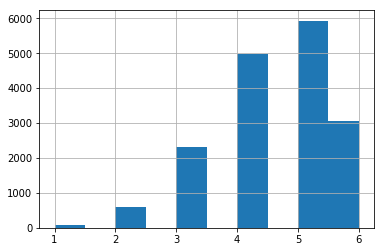

In [54]:
#group event=offer received per person in transactional records
print(transcript_processed[transcript_processed['event']=='offer received'].groupby('person')['event'].count().head())

#visualize offers received per person
transcript_processed[transcript_processed['event']=='offer received'].groupby('person')['event'].count().hist();

The transactional data showed that each person could receive between 1 to 6 offers. I had a theory that receiving offers more frequently could lead to more effective offers. To test this hypothesis, I created a new feature called "offer_received_cnt" that takes into account the frequency of offers received per person.

In [55]:
#get count of offers received per person, put into separate dataset
df_offer_received_cnt=transcript_processed[transcript_processed['event']=='offer received'].groupby(['person','offer_id','time']).count()['event'].reset_index()

#rename columns
df_offer_received_cnt.rename(columns={'event':'offer_received_cnt'},inplace=True)

#drop redundant columns
df_offer_received_cnt.drop(['time'], axis=1, inplace=True)

#ensure only unique person-offer_id pairs
df_offer_received_cnt=df_offer_received_cnt.groupby(['person','offer_id']).sum().reset_index()

#### 3. Subtract the transactions which's not related to the offer

There may be some transactions that are not related to the offers and hence can be considered as 'invalid'. These are transactions from users in groups 3 and 4, who are loyal spenders and tend to purchase more irrespective of the offers. However, for users in group 1 who have a high amount of 'invalid spend' outside of the offers, there might be some predictive power to determine the effectiveness of offers as these users are loyal and might have a higher tendency to take up an offer. To identify these transactions, I had already separated the conversions from the normal purchasing behavior using the completed_offer column, where I checked if a transaction had an offer viewed event prior. I included the offer_completed=1 transactions in the effective offers flag for BOGO and Discount offers, but not for offer_completed=0 transactions. Thus, including the baseline level of 'invalid transactions' as a feature can help in predicting the propensity of a user to take up an offer and determine its effectiveness.

In [56]:
#filter dataset by invalid transactions
# subtract the transactions which's not related to the offer
transactions_not_related=transcript_processed[(transcript_processed['event']=='transaction') & (transcript_processed['completed_offer']==0)].groupby(['person','offer_id'])['amount'].sum().reset_index()
transactions_not_related.rename(columns={'amount':'amount_invalid'},inplace=True)

## Preparing data for implementation

We can start preparing the data for modeling with the following steps:

    a. Combine the temporary datasets with the main dataset to add engineered features.
    b. Remove missing values in the gender, income, and abnormal age value columns in the demographic data, and convert gender to dummy variables.
    c. Split the channel column into categorical variables.
    d. Handle duplicate records.

##### a. Merge with temporary datasets created above to include engineered features

In [57]:
# merge to get offers received count and invalid amount transacted 
offers_bogo=offers_bogo.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
offers_bogo=offers_bogo.merge(transactions_not_related[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

##### b. Drop missing values in gender column for demographic data

In [58]:
#check % of missing values in dataset
(offers_bogo.isnull().sum()/len(offers_bogo)*100).sort_values(ascending=False).head()

amount_invalid        96.323752
income                 7.057489
gender                 7.057489
offer_received_cnt     0.000000
membership_days        0.000000
dtype: float64

The amount_invalid column has a high proportion of missing data (97%) and may not provide much information for BOGO offers. We will reevaluate this feature during the model implementation phase, but for now we fill the missing values with 0. Additionally, we drop the income and gender columns as they are not useful when they have missing values.

In [59]:
# fill missing values for amount_invalid with 0
offers_bogo['amount_invalid']=offers_bogo['amount_invalid'].fillna(value=0)
offers_bogo.dropna(inplace=True)

##### c. Separate the channel column into categorical variables

In [60]:
#foresee need to reuse dummy variable encoding function
def dummy(df,col):
    df=pd.concat([df[:],pd.get_dummies(df[col],prefix=col)],axis=1)
    df=df.drop(columns=col,axis=1,inplace=False)
    return df

In [61]:
#merge with portfolio to get offer details
offers_bogo=offers_bogo.merge(portfolio,how='left',on='offer_id')

#convert channels into categorical variables
for index, row in offers_bogo.iterrows():
    for channel in ['web', 'email', 'social', 'mobile']:
        if channel in offers_bogo.loc[index, 'channels']:
            offers_bogo.loc[index, channel] = 1
        else:
            offers_bogo.loc[index, channel] = 0

In [62]:
offers_bogo = offers_bogo.drop(['channels'], axis=1, inplace=False)

#convert gender into categorical variables
offers_bogo=dummy(offers_bogo,'gender')

In [63]:
offers_bogo.head()

,person,offer_id,effective_offer,age,income,membership_days,offer_received_cnt,amount_invalid,difficulty,duration,offer_type,reward,web,email,social,mobile,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40,57000.0,39.0,1,0.0,5,7,bogo,5,1.0,1.0,0.0,1.0,0,0,1
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59,90000.0,824.0,1,0.0,10,5,bogo,10,1.0,1.0,1.0,1.0,1,0,0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24,60000.0,1071.0,1,0.0,5,7,bogo,5,1.0,1.0,0.0,1.0,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24,60000.0,1071.0,1,0.0,5,5,bogo,5,1.0,1.0,1.0,1.0,1,0,0
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55,74000.0,158.0,1,0.0,5,5,bogo,5,1.0,1.0,1.0,1.0,1,0,0


In [64]:
def prep_offers_df(df):
    '''
    inputs:
    - df: original dataframe for modeling 
    
    outputs:
    - Returns dataframe containing engineered features, filled missing values and cleaned and transformed variables (channel and gender)
       
    '''
    # Merge to get engineered features 
    df = pd.merge(df, df_offer_received_cnt, on=['person', 'offer_id'], how='left')
    df = pd.merge(df, transactions_not_related, on=['person', 'offer_id'], how='left')
    
    # Fill missing values for amount_invalid with 0
    df['amount_invalid'].fillna(0, inplace=True)
    
    # Drop income and gender null rows
    df.dropna(subset=['income', 'gender'], inplace=True)
    
    # Merge with portfolio to get offer details
    df = pd.merge(df, portfolio, on='offer_id', how='left')

    # Convert channels into categorical variables
    channels = ['web', 'email', 'social', 'mobile']
    for channel in channels:
        df[channel] = df['channels'].apply(lambda x: channel in x).astype(int)
    df.drop('channels', axis=1, inplace=True)
    
    # Convert gender column into dummy variables
    df = pd.get_dummies(df, columns=['gender'])

    return df

In [65]:
#prepare data for offer_discounts
offers_discount=prep_offers_df(offers_discount)

In [66]:
offers_discount.head()

,person,offer_id,effective_offer,age,income,membership_days,offer_received_cnt,amount_invalid,difficulty,duration,offer_type,reward,web,email,social,mobile,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,40,57000.0,39.0,1,0.0,20,10,discount,5,1,1,0,0,0,0,1
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,40,57000.0,39.0,1,0.0,7,7,discount,3,1,1,1,1,0,0,1
2,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1,59,90000.0,824.0,2,0.0,10,10,discount,2,1,1,1,1,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,1,24,60000.0,1071.0,1,0.0,7,7,discount,3,1,1,1,1,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,1,26,73000.0,566.0,2,0.0,10,10,discount,2,1,1,1,1,1,0,0


In [67]:
#merge with portfolio to get offer details
offers_info=offers_info.merge(portfolio,how='left',on='offer_id')

#reset index for offers_info
offers_info = offers_info.reset_index().drop(['index'],axis=1,inplace=False)


#convert channels into categorical variables
for index, row in offers_info.iterrows():
    for channel in ['web', 'email', 'social', 'mobile']:
        if channel in offers_info.loc[index, 'channels']:
            offers_info.loc[index, channel] = 1
        else:
            offers_info.loc[index, channel] = 0
offers_info = offers_info.drop(['channels'], axis=1, inplace=False)

In [68]:
#repurpose function for offers_info
def prep_offers_df(df):
    '''
    inputs:
    - df: dataframe to be transformed 
    
    outputs:
    - Returns dataframe with engineered features and filled missing values, with transformed gender column.
       
    '''
    #merge to get engineered features 
    df=df.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
    df=df.merge(transactions_not_related[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

    #fill missing values for amount_invalid and offer_received_cnt with 0
    df['amount_invalid']=df['amount_invalid'].fillna(value=0)
    df['offer_received_cnt']=df['offer_received_cnt'].fillna(value=0)

    #drop rows with null values for gender, income, or age
    df.dropna(subset=['gender','income','age'], inplace=True)

    #convert gender column into dummy variables
    df=dummy(df,'gender')
    
    return df


In [69]:
offers_info=prep_offers_df(offers_info)
offers_info.head()

,person,offer_id,effective_offer,age,income,membership_days,difficulty,duration,offer_type,reward,web,email,social,mobile,offer_received_cnt,amount_invalid,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33,72000.0,506.0,0,4,informational,0,1.0,1.0,0.0,1.0,1.0,0.00,0,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33,72000.0,506.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,0.00,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,1,59,90000.0,824.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,0.00,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,1,24,60000.0,1071.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,16.27,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1,26,73000.0,566.0,0,4,informational,0,1.0,1.0,0.0,1.0,1.0,0.00,1,0,0


## Implementation

The datasets are now ready for model implementation, with the target feature being effective_offer. Since there are three offer types, three separate binary classification supervised learning models need to be built. A simple decision tree classifier model was chosen as the baseline model for comparison with an ensemble random forest classifier model. Tree-based models were chosen to ensure interpretability of the model since the project aims to predict whether the customer will respond to the different types of offers or not. Random Forest was selected as an alternate model to compare with the baseline model. Before proceeding with model implementation, class balance in each dataset needs to be ensured.

In [70]:
#check for class balance in datasets
print(offers_bogo[['person','effective_offer']].groupby('effective_offer').count()/len(offers_bogo))
print(offers_discount[['person','effective_offer']].groupby('effective_offer').count()/len(offers_discount))
print((offers_info[['person','effective_offer']].groupby('effective_offer').count()/len(offers_info)))

                  person
effective_offer         
0                0.17783
1                0.82217
                   person
effective_offer          
0                0.135256
1                0.864744
                   person
effective_offer          
0                0.252318
1                0.747682


In summary, the classes for all three offer types are somewhat uneven but not imbalanced enough to be problematic. The models can be implemented, but it's important to note that the evaluation and validation should consider both accuracy and f1 score due to the imbalanced classes. F1 score is a better metric because it considers false positives and false negatives in the calculation, which is more useful when there's uneven class distribution. Focusing on the F1 score is appropriate for this Starbucks app because the priority is on whether offers are effective, rather than the reasons for their ineffectiveness.

#### a. Model Implementation

We will make 3 models to predict offer effectiveness based on offer attributes and user demographics. Before that, we need to define our target and feature variables.

In [71]:
def data_prep(df, col_drop):
    '''
    inputs:
    - df: prepared dataframe for modeling
    - col_drop: list of columns to be dropped
    
    outputs:
    - Returns two dataframes - features and target dataframes
    '''
    # Split the data into features and target label
    features = df.drop(columns=col_drop)
    target = df['effective_offer']
    
    return features, target

Then, the data is divided into a training set and a test set. To address the issue of the features being on different scales, a scaler is applied to standardize the data before training.

In [72]:
def model_pipeline(features, target):
    '''
    inputs:
    - features: dataframe containing the features
    - target: dataframe containing the target
    
    outputs:
    - X_train: dataframe containing the training features
    - X_test: dataframe containing the testing features
    - y_train: dataframe containing the training target
    - y_test: dataframe containing the testing target
    '''
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In this step, defining a function that can be used to run three different models more efficiently. The function includes the model scores such as F1 score and accuracy, along with the error rate or mean squared error.

In [73]:
def train_predict(model, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - model: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: target variable training set
       - X_test: features testing set
       - y_test: target variable testing set
       
    outputs:
    - Prints training time, testing time, mean squared error, training accuracy, testing accuracy, and classification report. Returns dictionary of results.
    '''
    results = {}
    
    # Fit the model to the training data and get training time
    start = time() 
    model.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end - start
    
    # Get predictions on the test set
    start = time() 
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)
    end = time() 
    
    # Calculate the prediction time
    results['pred_time'] = end - start
    
    # Add training accuracy to results
    results['training_score'] = model.score(X_train, y_train)
    
    # Add testing accuracy to results
    results['testing_score'] = model.score(X_test, y_test)
     
    print(f"{model.__class__.__name__} trained on {len(y_train)} samples.")
    print(f"MSE_train: {mean_squared_error(y_train, predictions_train):.4f}")
    print(f"MSE_test: {mean_squared_error(y_test, predictions_test):.4f}")
    print(f"Training accuracy: {results['training_score']:.4f}")
    print(f"Test accuracy: {results['testing_score']:.4f}")
    print(classification_report(y_test, predictions_test, digits=4))
    
    return results

In [74]:
def run_model(clf1,clf2,name):
    '''
    inputs:
    - clf1: first classifier model
    - clf2: 2nd classifier model for comparison
    - name: name of models for comparison
    
    outputs:
    - Dataframe of results from model training and prediction
    '''
    
    # Collect results on the learners
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__ + '_' +name
        results[clf_name] = {}
        results[clf_name]= train_predict(clf, X_train, y_train, X_test, y_test)
    return pd.DataFrame(results)

#### 1. BOGO offers model

To start with, the BOGO offers model is being built. The models are initialized with randomly selected parameters to assess their initial performance. If the performance needs to be further enhanced, the Grid Search technique will be utilized to determine the optimal parameters.

In [75]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model - baseline is DT model, bogo_1 model is RF model
baseline = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=2,min_samples_split=90,min_samples_leaf=50)
bogo_1 = RandomForestClassifier(random_state=2,max_depth= 11, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=20)

results=run_model(baseline,bogo_1,'bogo_1')

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1777
MSE_test: 0.1782
Training accuracy: 0.8223
Test accuracy: 0.8218
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       438
          1     0.8218    1.0000    0.9022      2020

avg / total     0.6754    0.8218    0.7414      2458



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1626
MSE_test: 0.1733
Training accuracy: 0.8374
Test accuracy: 0.8267
             precision    recall  f1-score   support

          0     0.5732    0.1073    0.1808       438
          1     0.8354    0.9827    0.9031      2020

avg / total     0.7887    0.8267    0.7744      2458



In the initial attempt to build the BOGO offers model, both Random Forest Classifier and Decision Tree Classifier were initialized with random parameters to check the initial performance. The accuracy of both models was around 82%, with the Random Forest model slightly outperforming the Decision Tree Classifier. However, both models had F1 scores below 80%, with the Random Forest model performing slightly better in not misclassifying negative events as positive. This is expected due to the uneven classes, and since the aim is to not miss anyone on which an offer would have been effective, the RF model was selected. Feature importances will be checked after refining the model.

#### 2. Discount offers model

In [76]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_1 = RandomForestClassifier(random_state=2,max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)
results=pd.concat([results[:],run_model(baseline,discount_1,'discount_1')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy: 0.8629
Test accuracy: 0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1271
MSE_test: 0.1265
Training accuracy: 0.8729
Test accuracy: 0.8735
             precision    recall  f1-score   support

          0     0.5652    0.0400    0.0747       325
          1     0.8763    0.9955    0.9321      2220

avg / total     0.8366    0.8735    0.8226      2545



The Decision Tree Classifier model also has a better performance compared to the Random Forest Classifier in terms of accuracy (87.07% vs 87.23%), and the F1 score is also lower (81.71% vs 81.28%).

In [77]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_1 = RandomForestClassifier(random_state=5,criterion='gini',max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)

results=pd.concat([results[:],run_model(baseline,info_1,'info_1')],axis=1)

DecisionTreeClassifier trained on 5780 samples.
MSE_train: 0.2394
MSE_test: 0.2388
Training accuracy: 0.7606
Test accuracy: 0.7612
             precision    recall  f1-score   support

          0     0.5926    0.0901    0.1565       355
          1     0.7678    0.9798    0.8609      1090

avg / total     0.7248    0.7612    0.6879      1445

RandomForestClassifier trained on 5780 samples.
MSE_train: 0.2234
MSE_test: 0.2394
Training accuracy: 0.7766
Test accuracy: 0.7606
             precision    recall  f1-score   support

          0     0.5672    0.1070    0.1801       355
          1     0.7700    0.9734    0.8598      1090

avg / total     0.7201    0.7606    0.6928      1445



The performance of the models for the informational offers is not as good as the other two datasets, with both the Random Forest Classifier and Decision Tree Classifier models having an accuracy below 80%, but the Random Forest Classifier model still performing better. The F1 score is also worse compared to the other two offers, with the Random Forest Classifier model at 68.23%, which is worse than the Decision Tree Classifier model at 69.72%.

The worse performance could be attributed to the assumption made to assign the conversion events only to transactions that occur after an offer is viewed and within the specified duration. This assumption may have resulted in the removal of valuable information that could have improved the models. The sample dataset for the informational offers is also smaller, with only about 5,000 samples, which is about half the sample size of the BOGO and discount offers.

#### b. Refinement

To improve the model's performance, I will start by tuning the parameters for the 3 RF models. After that, I will experiment with adding or removing features.

In [84]:
def best_model(offer_type):
    '''
    input:
    - offer_type: string of offer type name
    output:
    - dataframe containing results of best model so far
    
    '''
    print('For ' + offer_type + ' RF model:')
    return results.transpose()[results.transpose()['testing_score']==results.transpose()[results.transpose().index.str.contains("RandomForestClassifier_"+offer_type)]['testing_score'].max()]

##### 1. Grid Search to discover optimal parameters

To find the best parameters for the model, Grid Search was used on all three offers. The Random Forest model showed good performance for all offers, so it was chosen for the Grid Search.

In [85]:
#define Grid Search function
def rand_forest_param_selection(X, y):
    '''
    inputs:
    - X: features training set
    - y: target training set
    
    output:
    - dictionary with best hyperparameters for the random forest classifier
    '''
    param_grid = {
        'max_features': ['auto', 'sqrt'],
        'max_depth': [5, 10, 15, 20],
        'n_estimators': [25, 30, 40, 50],
        'min_samples_split': [2, 10, 20],
        'min_samples_leaf': [2, 10, 15, 20]
    }
    
    grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid)
    grid_search.fit(X, y)
    
    return grid_search.best_params_

In [86]:
#define BOGO dataset
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#run Grid Search - commented out because takes to long to run, but have put in selected params in model
rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 40}

After obtaining the optimal parameters for the BOGO model using Grid Search, the model was run again with the new parameters. The Decision Tree model was kept with the same parameters as a baseline comparison.

In [87]:
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
bogo_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=25,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,bogo_2,'bogo_2')],axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1777
MSE_test: 0.1782
Training accuracy: 0.8223
Test accuracy: 0.8218
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       438
          1     0.8218    1.0000    0.9022      2020

avg / total     0.6754    0.8218    0.7414      2458



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1549
MSE_test: 0.1701
Training accuracy: 0.8451
Test accuracy: 0.8299
             precision    recall  f1-score   support

          0     0.6190    0.1187    0.1992       438
          1     0.8374    0.9842    0.9049      2020

avg / total     0.7985    0.8299    0.7791      2458



In [88]:
results[['RandomForestClassifier_bogo_1','RandomForestClassifier_bogo_2']]

,RandomForestClassifier_bogo_1,RandomForestClassifier_bogo_2,RandomForestClassifier_bogo_2
pred_time,0.027719,0.034662,0.031784
testing_score,0.826688,0.829943,0.829943
train_time,0.188813,0.195131,0.212960
training_score,0.837420,0.845050,0.845050


In [89]:
#find best model so far for BOGO offer type
best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_2,0.034662,0.829943,0.195131,0.84505
RandomForestClassifier_bogo_2,0.031784,0.829943,0.212960,0.84505


The accuracy of the RF model improved by 0.04% (from 82.83% to 82.87%) and the F1 score increased by 0.87% (from 76.70% to 77.57%) after performing Grid Search. Though the performance increase is positive, it is still relatively minimal, suggesting that further improvement cannot be achieved through parameter tuning. Therefore, other methods such as exploring features need to be explored to enhance the model's performance.

In [90]:
#define discount dataset
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

# run Grid Search - commented out because takes to long to run, but have put in selected params in model
rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 40}

In [91]:
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 2,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,discount_2,'discount_2')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy: 0.8629
Test accuracy: 0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1274
MSE_test: 0.1273
Training accuracy: 0.8726
Test accuracy: 0.8727
             precision    recall  f1-score   support

          0     0.5238    0.0338    0.0636       325
          1     0.8756    0.9955    0.9317      2220

avg / total     0.8307    0.8727    0.8208      2545



In [92]:
results[['RandomForestClassifier_discount_1','RandomForestClassifier_discount_2']]

,RandomForestClassifier_discount_1,RandomForestClassifier_discount_2
pred_time,0.029015,0.041547
testing_score,0.873477,0.872692
train_time,0.274440,0.289804
training_score,0.872876,0.872581


In [93]:
#find best model so far for discount offer type
best_model('discount')

For discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_1,0.029015,0.873477,0.27444,0.872876


The model's accuracy slightly improved from 87.07% to 87.39%, and the F1 score increased from 81.71% to 82.08%, which is an improvement. The RF model now outperforms the DT model in terms of both accuracy and F1 score. However, the improvement was minimal, suggesting that parameter tuning may not have a significant impact on the model's performance.

In [94]:
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#run Grid Search - commented out because takes to long to run, but have put in selected params in model
rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 30}

In [95]:
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_2 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=25,min_samples_leaf=20)

results=pd.concat([results[:],run_model(baseline,info_2,'info_2')],axis=1)

DecisionTreeClassifier trained on 5780 samples.
MSE_train: 0.2394
MSE_test: 0.2388
Training accuracy: 0.7606
Test accuracy: 0.7612
             precision    recall  f1-score   support

          0     0.5926    0.0901    0.1565       355
          1     0.7678    0.9798    0.8609      1090

avg / total     0.7248    0.7612    0.6879      1445

RandomForestClassifier trained on 5780 samples.
MSE_train: 0.2369
MSE_test: 0.2408
Training accuracy: 0.7631
Test accuracy: 0.7592
             precision    recall  f1-score   support

          0     0.5714    0.0789    0.1386       355
          1     0.7658    0.9807    0.8600      1090

avg / total     0.7180    0.7592    0.6828      1445



In [96]:
results[['RandomForestClassifier_info_1','RandomForestClassifier_info_2']]

,RandomForestClassifier_info_1,RandomForestClassifier_info_2
pred_time,0.016664,0.018764
testing_score,0.760554,0.759170
train_time,0.103728,0.142080
training_score,0.776644,0.763149


In [97]:
#find best model so far for info offer type
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_1,0.016664,0.760554,0.103728,0.776644


The RF model shows a slight increase in accuracy from 74.87% to 75.23%, but a small decrease in F1 score from 68.23% to 67.14%. As the improvement is minimal, the focus will now shift towards improving the feature selection of the model.

##### 2. Removing sparse features e.g. amount_invalid

To improve feature selection, I decided to remove the amount_invalid variable, which we had previously identified as being sparse and potentially not useful in predicting the effectiveness of offers. After removing this feature from the data preparation, I retrained the model using the same optimal parameters found via GridSearch, with the DT model serving as a baseline.

In [98]:
#add amount_invalid variable to drop_cols_prep list
drop_cols_prep=['person','offer_id','effective_offer','offer_type','amount_invalid']

#train BOGO model
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
bogo_3 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=25,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,bogo_3,'bogo_3')],axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1764
MSE_test: 0.1745
Training accuracy: 0.8236
Test accuracy: 0.8255
             precision    recall  f1-score   support

          0     0.5283    0.1918    0.2814       438
          1     0.8460    0.9629    0.9007      2020

avg / total     0.7894    0.8255    0.7903      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1552
MSE_test: 0.1705
Training accuracy: 0.8448
Test accuracy: 0.8295
             precision    recall  f1-score   support

          0     0.6267    0.1073    0.1832       438
          1     0.8359    0.9861    0.9048      2020

avg / total     0.7986    0.8295    0.7763      2458



In [99]:
results[['RandomForestClassifier_bogo_2','RandomForestClassifier_bogo_3']]

,RandomForestClassifier_bogo_2,RandomForestClassifier_bogo_2,RandomForestClassifier_bogo_3
pred_time,0.034662,0.031784,0.038054
testing_score,0.829943,0.829943,0.829536
train_time,0.195131,0.212960,0.236447
training_score,0.845050,0.845050,0.844847


In [100]:
#find best model so far for BOGO offer type
best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_2,0.034662,0.829943,0.195131,0.84505
RandomForestClassifier_bogo_2,0.031784,0.829943,0.212960,0.84505


The accuracy and F1 score of the model remained the same after removing the amount_invalid feature, so I have decided not to exclude it from my model.

In [101]:
#train discount model
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_3 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 2,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,discount_3,'discount_3')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy: 0.8629
Test accuracy: 0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1242
MSE_test: 0.1277
Training accuracy: 0.8758
Test accuracy: 0.8723
             precision    recall  f1-score   support

          0     0.5000    0.0338    0.0634       325
          1     0.8755    0.9950    0.9315      2220

avg / total     0.8276    0.8723    0.8206      2545



In [102]:
results[['RandomForestClassifier_discount_2','RandomForestClassifier_discount_3']]

,RandomForestClassifier_discount_2,RandomForestClassifier_discount_3
pred_time,0.041547,0.043294
testing_score,0.872692,0.872299
train_time,0.289804,0.286807
training_score,0.872581,0.875823


In [103]:
#find best model so far for discount offer type
best_model('discount')

For discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_1,0.029015,0.873477,0.27444,0.872876


The accuracy of the model did not increase by removing the amount_invalid feature, so I will keep it in the discount model.

In [104]:
#train info model
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_3 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=25,min_samples_leaf=20)

results=pd.concat([results[:],run_model(baseline,info_3,'info_3')],axis=1)

DecisionTreeClassifier trained on 5780 samples.
MSE_train: 0.2410
MSE_test: 0.2388
Training accuracy: 0.7590
Test accuracy: 0.7612
             precision    recall  f1-score   support

          0     0.6389    0.0648    0.1176       355
          1     0.7644    0.9881    0.8619      1090

avg / total     0.7335    0.7612    0.6791      1445

RandomForestClassifier trained on 5780 samples.
MSE_train: 0.2377
MSE_test: 0.2429
Training accuracy: 0.7623
Test accuracy: 0.7571
             precision    recall  f1-score   support

          0     0.5435    0.0704    0.1247       355
          1     0.7641    0.9807    0.8590      1090

avg / total     0.7099    0.7571    0.6786      1445



In [105]:
results[['RandomForestClassifier_info_2','RandomForestClassifier_info_3']]

,RandomForestClassifier_info_2,RandomForestClassifier_info_3
pred_time,0.018764,0.019692
testing_score,0.759170,0.757093
train_time,0.142080,0.138212
training_score,0.763149,0.762284


In [106]:
#find best model so far for info offer type
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_1,0.016664,0.760554,0.103728,0.776644


The accuracy and F1 score of the model for the information offer increased slightly, but not significantly. Therefore, I will keep the feature of amount_invalid in the model.

##### 5. Discussion on best models and feature importances:

After refining the three models, it is time to assess the results of the best models for all three and examine the feature importances to identify the primary factors that contribute to the effectiveness of offers.

In [107]:
#get best model overall for bogo,discount and info offers
best_model('bogo').append([best_model('discount'),best_model('info')]).transpose()

For bogo RF model:
For discount RF model:
For info RF model:


,RandomForestClassifier_bogo_2,RandomForestClassifier_bogo_2,RandomForestClassifier_discount_1,RandomForestClassifier_info_1
pred_time,0.034662,0.031784,0.029015,0.016664
testing_score,0.829943,0.829943,0.873477,0.760554
train_time,0.195131,0.212960,0.274440,0.103728
training_score,0.845050,0.845050,0.872876,0.776644


After refining all three models, we have identified that the second model with optimal parameters and removal of the amount_invalid column is the best performing model for predicting the effectiveness of BOGO, discount and informational offers. In order to determine the most important factors in predicting the effectiveness of an offer, we can analyze the feature importances of the top performing models.

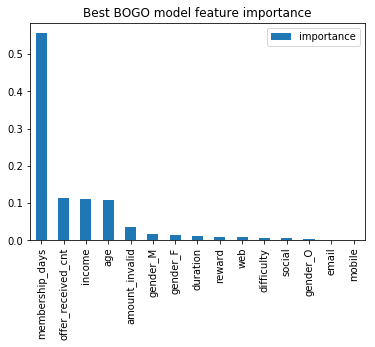

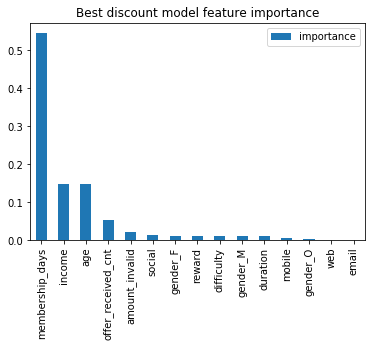

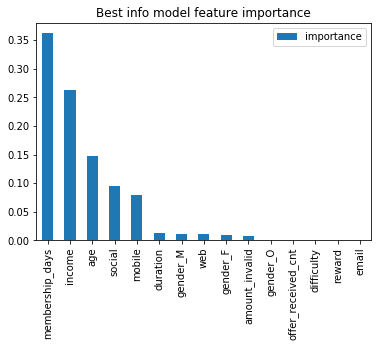

In [108]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_bogo,drop_cols_prep)

feature_importances = pd.DataFrame(bogo_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best BOGO model feature importance')
plt.show()

#discount 3 model
feature_importances = pd.DataFrame(discount_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best discount model feature importance')
plt.show()

#info_2 model
#prepare data similar to info_2 state
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_discount,drop_cols_prep)
#print feature importance
feature_importances = pd.DataFrame(info_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best info model feature importance')
plt.show()

When analyzing the main drivers of effective offers using feature importance, we can see that membership tenure is the most important driver across all three models. This means that the longer a customer has been a member of Starbucks, the more likely they are to respond positively to the offers they receive. Additionally, income is the second most important feature for all three models.

For the BOGO model, membership tenure is the most important feature, while income, age, and offer_received_cnt follow but with very small proportions.

For the discount model, after membership tenure, age and income are the next most important variables but still with small proportions.

As for the informational offer models, the feature importances are more evenly distributed compared to the BOGO and discount models, with income being the second most important feature, age as the third, and social channel interestingly being the fourth most important.

In [109]:
results

,DecisionTreeClassifier_bogo_1,RandomForestClassifier_bogo_1,DecisionTreeClassifier_discount_1,RandomForestClassifier_discount_1,DecisionTreeClassifier_info_1,RandomForestClassifier_info_1,DecisionTreeClassifier_bogo_2,RandomForestClassifier_bogo_2,DecisionTreeClassifier_bogo_2,RandomForestClassifier_bogo_2,DecisionTreeClassifier_discount_2,RandomForestClassifier_discount_2,DecisionTreeClassifier_info_2,RandomForestClassifier_info_2,DecisionTreeClassifier_bogo_3,RandomForestClassifier_bogo_3,DecisionTreeClassifier_discount_3,RandomForestClassifier_discount_3,DecisionTreeClassifier_info_3,RandomForestClassifier_info_3
pred_time,0.000888,0.027719,0.001181,0.029015,0.000492,0.016664,0.000994,0.034662,0.000935,0.031784,0.001309,0.041547,0.000490,0.018764,0.000998,0.038054,0.001336,0.043294,0.000742,0.019692
testing_score,0.821806,0.826688,0.872299,0.873477,0.761246,0.760554,0.821806,0.829943,0.821806,0.829943,0.872299,0.872692,0.761246,0.759170,0.825468,0.829536,0.872299,0.872299,0.761246,0.757093
train_time,0.019911,0.188813,0.020124,0.274440,0.010008,0.103728,0.019158,0.195131,0.018739,0.212960,0.023136,0.289804,0.010265,0.142080,0.020474,0.236447,0.060967,0.286807,0.011888,0.138212
training_score,0.822261,0.837420,0.862855,0.872876,0.760554,0.776644,0.822261,0.845050,0.822261,0.845050,0.862855,0.872581,0.760554,0.763149,0.823583,0.844847,0.862855,0.875823,0.758997,0.762284


### Conclusion:

Question 1: The top predictor of offer effectiveness across all three models was found to be membership tenure. The second and third most important features were income and age, with the order varying slightly depending on the offer type. For BOGO and discount offers, the feature importance distribution was relatively equal, while for informational offers, it was more balanced with income being the second most important variable.

Question 2: Using 3 separate models to predict the effectiveness of each offer type proved to be a good decision, with high accuracy for BOGO and discount models (82.87% for BOGO and 87.38% for discount), while slightly lower accuracy for the informational offers (75.23%). Nonetheless, I consider 75% accuracy to be acceptable in a business context since informational offers do not incur any cost.

I am satisfied with the 80% and above accuracy for BOGO and discount models since it would be acceptable to present offers to customers in a business setting. Even if the model makes a few misclassifications, the overall revenue increase may justify the errors.

#### Main challenges and potential improvement:

During the project, there were a few challenges and findings that I reflected upon:

i. Attribution framework:
Defining an attribution model for the conversion events was the most challenging part of the project. I had to separate the users into four different groups based on their actions, and even after that, it was challenging to assign people in group 3 based on the transactional data. I had to define the event space before I could assign an offer id to transactions.

ii. Feature engineering:
I had to decide which features to re-engineer and how to engineer them for an effective model. At the end, membership tenure was the most important feature.

iii. Model implementation decisions:
I decided to build three separate models depending on offer types. I believed it made more sense to remove noise from the data by separating the data into offer types. The single BOGO and discount models had good performance in testing scores. The info model's accuracy was slightly worse as we had less data overall.

An additional note on model selection - I selected tree-based models as I wanted to assess feature importance. However, I could have extended this study further by testing a parametric/regression model. The weights of the coefficients from a regression model might have been interesting to contrast with the feature importance of a tree-based model.